# ByBit インバースデリバティブのバックテストプログラム


![全体図](https://github.com/yasstake/botframe/raw/main/rust/botframework/TEST/python/outline.png)

## プログラム概要
Bybitの約定ログを使ってバックテストを行うプログラムです。１日あたり数十万レコードあるログを処理するためかなり重い処理になりますが、大きな注文を行うと約定しないということもバックテスト可能になっています（板情報がないため、このリリースではMakerのみ実装です）

## 処理の流れ
「rbot全体アーキテクチャ」の図のとおり以下の処理を行います。

1) rbot.DummyBb#data_load関数でByBitの `https://public.bybit.com/trading/BTCUSD/`からデータをダウンロードします。直近のn日のデータをダウンロードできるように指定できます。
2) rbot.DummyBb#run関数でAgentと実行間隔(sec)を指定しバックテストを開始します。
3) バックテスターは与えられたAgentに実装されている`on_clock`関数を探し`Session`オブジェクトを引数にして呼び出します。
4) ユーザが記述した`on_clocok`の中でSessionで提供されるAPIを使って売買ロジックを実行します。
   1) 最初に`Session#ohlcv`でローソク足を取得し売買判断をする（ローソク足はバックテストの最初は全部揃っていない場合があるので注意）
   2) 次に前回の`on_clock`で出したオーダの状態を確認し、本当に売買するか決定します。たとえば、オーダーが処理中ならば止める、逆サイドのポジションがあったらドテンなど判断することができます。
   3) オーダすることがきまればOrderオブジェクトを作り`on_clock`関数の戻り値として返します（オーダーをしない場合はなにも返さなければOK)
5) 全ログに対しバックテストが終わるとセッション結果が戻ってくるので、分析する。



## 環境の準備と実行にむけたステップ

３のAgentは自分のロジックを作る必要がありますが、他のステップはこのnotebookをそのまま利用することが可能。

0) python3/jupyter notebookのインストール（すでにある前提）
1) 必要なライブラリのインストール
2) DummyBbクラスの生成とデータのロード
3) Agent(任意名）クラスの作成 (独自のロジックをつくるのはここだけ)
4) バックテスト実行
5) 分析

以後実際に動くコードと共に順番に説明します。

## 1. 必要なパッケージのインストールとpythonでのimport

必要な以下のパッケージをコマンドラインでインストールする。

* pandas      表データの管理・処理
* mplfinance  金融データのグラフ表示
* matplotlib  mplfinance中で使われているグラフ表示ライブラリ

```
$ pip install pandas
$ pip install matplotlib
$ pip install mplfinance
```

* rbot        バックテスト用のライブラリ。別途入手してインストールする
                （事前にRustコンパイラをインストールしたあとで以下でOK）

```
$ pip install rbot-xxx-xxx.tar.gz
```

In [1]:
# 必要ライブラリのインポート

import pandas as pd
import mplfinance as mpf
import rbot


## 2.　rbot.DummyBbクラスの生成とデータのロード

### DummyBb クラスとメソッドの解説

| 関数名 | rbot.DummyBb() |
|-----|-------------|
| 役割 | バックテストクラスのコンストラクタ|
|**引数**　| |
|(なし)　　　| |
|戻り値|DummyBbオブジェクト    |

#

| 関数名 | load_data(n_days) |
|-----|-------------|
| 役割 | 指定期間のデータをロードする|
|**引数**　| |
| n_days　　　| ダウンロードする日数。最新からの日数を指定する。|
|**戻り値**| （なし）    |

#

| 関数名 | `__str__` |
|-----|-------------|
| 役割 | 人間のわかるフォーマットで状態を表示する。データの開始・終了時間、レコード数が表示される。時刻はms単位で表現|
|**引数**　| |
| (なし)　　　||
|**戻り値**| データの開始・終了、レコード数を文字列で表現したもの |
#
| 関数名 | ohlcv(start_time_ms, end_time_ms, width_sec)|
|-----|-------------|
| 役割 | ohlcv（ローソク足データ）を作る。|
|**引数**　| |
|start_time_ms|ohlcv開始時刻[ms]。0を指定するとデータの最初から|
| end_time_ms|ohlcv終了時刻[ms]。0を指定するとデータの最後まで|
| width_sec)|ローソク足の時間幅[sec]|
|**戻り値**| ohlcvをarray形式にしたもの。この戻り値をpandasのDataFrameへ変換するヘルパー関数 `rbot.array_to_df`が準備されている。 |
#
| 関数名 | run(agent, interval_sec)
|-----|-------------|
| 役割 | バックテストを行う。|
|**引数**　| |
|agent|on_tick関数を実相しているbot|
|interval_sec|agentを呼び出す時間間隔[sec]|
|**戻り値**| 実行結果。この戻り値をpandasのDataFrameへ変換するヘルパー関数 `rbot.result_to_df`が準備されている。 |
#




In [2]:
# DummyBbオブジェクトの作成とデータロード。100日分だと１分以上かかることがあります。
bb = rbot.DummyBb()
bb.log_load(100)

In [3]:
# ロード状況の確認 (__str__ メソッドの呼び出し)
# データの開始、終了、レコード数とログデータのダウンロード先が確認できます。
# 不要になったら、data_dirをみてデータの削除を手動でお願いします。
print(bb)

DummyBB: from:1647907200000("2022-03-22-00:00:00.000") to:1656547199000/("2022-06-29-23:59:59.000") rec_no:30173008 data_dir "/Users/takeoyasukawa/Library/Application Support/net.takibi.rusty-exchange"


In [4]:
# 日足の作成（バックテスト自体には不要です）
# 任意の幅の足が作れるので、ここだけ使って独自の分析を行っても良いと思います。
# BUG: データーロード直後はデータがそろっていなくて、エラーがでることがあります。その場合少々まって再実行お願いします。
ohlcv_day_array = bb.ohlcv(0, 0, 60*60*24)      # 足の幅をsecで入力する　１日＝60秒x60分x24時間。
ohlcv_day_array

array([[1.64790720e+12, 4.09945000e+04, 4.34380000e+04, 4.08710000e+04,
        4.23570000e+04, 2.06081144e+09],
       [1.64799360e+12, 4.23565000e+04, 4.30270000e+04, 4.17105000e+04,
        4.28850000e+04, 1.47513259e+09],
       [1.64808000e+12, 4.28850000e+04, 4.42825000e+04, 4.26015000e+04,
        4.39920000e+04, 1.65258297e+09],
       [1.64816640e+12, 4.39925000e+04, 4.51050000e+04, 4.35790000e+04,
        4.43095000e+04, 1.63663662e+09],
       [1.64825280e+12, 4.43095000e+04, 4.47985000e+04, 4.40680000e+04,
        4.45295000e+04, 5.78459350e+08],
       [1.64833920e+12, 4.45295000e+04, 4.69735000e+04, 4.44340000e+04,
        4.68200000e+04, 1.48054953e+09],
       [1.64842560e+12, 4.68285000e+04, 4.82075000e+04, 4.66430000e+04,
        4.71390000e+04, 2.09737069e+09],
       [1.64851200e+12, 4.71390000e+04, 4.81100000e+04, 4.69425000e+04,
        4.74505000e+04, 1.79212087e+09],
       [1.64859840e+12, 4.74505000e+04, 4.77000000e+04, 4.64000000e+04,
        4.70480000e+04, 

In [5]:
# pandas.DataFrameへ変換し中身を確認
# バックテスト自体には不要です。
ohlcv_day_df = rbot.array_to_df(ohlcv_day_array)
ohlcv_day_df

,open,high,low,close,volume
timestamp,,,,,
2022-03-22 00:00:00+00:00,40994.5,43438.0,40871.0,42357.0,2.060811e+09
2022-03-23 00:00:00+00:00,42356.5,43027.0,41710.5,42885.0,1.475133e+09
2022-03-24 00:00:00+00:00,42885.0,44282.5,42601.5,43992.0,1.652583e+09
2022-03-25 00:00:00+00:00,43992.5,45105.0,43579.0,44309.5,1.636637e+09
2022-03-26 00:00:00+00:00,44309.5,44798.5,44068.0,44529.5,5.784594e+08
...,...,...,...,...,...
2022-06-25 00:00:00+00:00,21208.5,21600.0,20872.0,21471.0,6.590194e+08
2022-06-26 00:00:00+00:00,21469.0,21898.5,20937.0,21022.5,8.165906e+08
2022-06-27 00:00:00+00:00,21022.0,21539.0,20463.0,20709.0,1.034150e+09


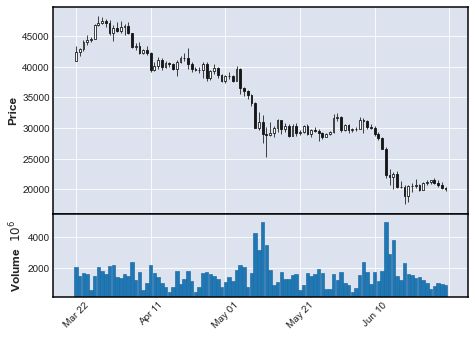

In [6]:
# ローソク足で表示して確認
mpf.plot(ohlcv_day_df, volume=True, type='candle')

## 2. Agent(任意名）クラスの作成 (独自のロジックをつくるのはここだけ)

bot本体は`on_clock`を実装しているクラスならば名前はなんでもOKです。
`on_clock`関数内では、受け取った`session`オブジェクトのAPIを使って売買判断をし、売買する場合に`Order`オブジェクトを作成返却するロジックを記載してください。

#
### botのクラスが実装するべき関数定義（名前・パラメータの一致が必要です）
| 関数名 | on_clock(time_ms, session)|
|-----|-------------|
| 役割 | バックテスト対象のbotのロジック（ユーザがつくるところ）|
|**引数**　| |
|time_ms|呼び出された時刻[ms]。|
|session|ロジックの中で使うSessionAPI用オブジェクト|
|**戻り値**| **なし**：なにもしない場合|
|     | **Orderオブジェクト**：botロジックの結果オーダ発行する場合|
#

## Sessionクラス
`on_clock`でSessionオブジェクトが渡されてくるので以下のAPIを使ってbotのロジックを完成させます。

### Sessionクラスプロパティ
| プロパティ| rbot.Session#current_time|
|-----|-------------|
| 役割 |　バックテスト中の現在時刻を取得する。最後の約定時刻のためon_tickで送られてくる時刻とは異なる（少し早い） |
|**戻り値**|現在時刻[ms] |
#

| プロパティ| rbot.Session#sell_edge_price|
|-----|-------------|
| 役割 |最後の買いオーダーから想定される、売り板の最安値（エッジ）。ギリ指を狙う場合はこの値でOrderを作る。 |
|**戻り値**| 売り板の最安値（エッジ）[ドル]|
#

| プロパティ| rbot.Session#buy_edge_price|
|-----|-------------|
| 役割 |最後の売りオーダーから想定される、買い板の最高値（エッジ）。ギリ指を狙う場合はこの値でOrderを作る。 |
|**戻り値**| 買い板の最高値（エッジ）[ドル]|
#

| プロパティ| rbot.Session#long_order_size|
|-----|-------------|
| 役割 | まだ処理中のLongオーダーの注文量の取得。前回のロジック実行時のオーダーがまだ処理されていないかの確認に使う。未オーダーまたは処理完了時は０となる。|
|**戻り値**| 処理中のLongオーダーの注文量[ドル]|
#

| プロパティ| rbot.Session#short_order_size|
|-----|-------------|
| 役割 | まだ処理中のShortオーダーの注文量の取得。前回のロジック実行時のオーダーがまだ処理されていないかの確認に使う。未オーダーまたは処理完了時は０となる。|
|**戻り値**| 処理中のShortオーダーの注文量[ドル]|
#

| 関数| rbot.Session#ohlcv(width_sec, count)|
|-----|-------------|
| 役割 | ohlcv（ローソク足）を取得する。現在時刻はSessionオブジェクトの状態を利用するので自動で更新されている。バックテストの初期（過去データが少ない）場合は、指定した本数の足が取得できない場合がある（少ない本数で帰ってくる）。|
|**引数**　| |
|width_sec|ローソク足の幅[sec]|
|count|必要なローソク足の本数（現在時刻から遡ってカウント）|
|（なし）||
|**戻り値**| ohlcvのarray。インデックスが大きいほうが最新データ。最新データは呼ばれるタイミングによっては未確定の数値となる場合がある。２時間足に対し、１時間刻みでon_clockを呼び出した場合など最後の足には１時間分しかデータがない。|
#



## Orderクラス

on_clock関数の中でオーダーを発行すると決定した場合に、このOrderオブジェクトを生成し戻り値とすることでオーダーを発行できます。

| 関数| rbot.Order(side, price, size, valid_sec, message)|
|-----|-------------|
| 役割 |  Orderクラスのコンストラクタ。botのロジックが売買を決めた場合、このオブジェクトを作成し`on_tick`の戻り値とする。|
|**引数**　| |
|side|買いの場合"Buy", 売りの場合"Sell|
| price|価格。Session.buy_edge_price, Session.sell_edge_priceを参考に入力する。本来は値によっては成り行きになるが、未実装（すべてが指値）|
|size|注文量[ドル]|
| valid_sec|注文有効期間[sec]|
|message|ログに出力されるときの識別子。デバック用に自由に利用|
|**戻り値**| Orderオブジェクト|
#




### バックテストするBotのサンプル

Ukiさんの「オープニングレンジ・ブレイクアウト」を実装してみた。
on_clickが２時間ごとに呼ばれるようにして、その中で過去５本と最新１本の６本足を使って計算している。
かなりストレートな実装ができると思う。（期待感としては本番のBotもあまり形を変えずに実装できるはず）

<blockquote class="twitter-tweet"><p lang="ja" dir="ltr">お待ちかねのロジックを公開。<br>(元祖)ドテン君はブレイクアウトだが通常のHLチャネルブレイクではない。その手法は「オープニングレンジ・ブレイクアウト」と呼ばれるものである。文章での説明は面倒なのでhohetoとの会議資料をそのまま添付する。ストラテジーに関する質問には応対できません。 <a href="https://t.co/LB6mdxVZZo">pic.twitter.com/LB6mdxVZZo</a></p>&mdash; UKI (@blog_uki) <a href="https://twitter.com/blog_uki/status/981768546429448192?ref_src=twsrc%5Etfw">April 5, 2018</a></blockquote> <script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script>

![](https://pbs.twimg.com/media/DZ_xJQFUMAEOrpS?format=jpg&name=900x900)

### BreakOutAgentの実装

In [30]:
class BreakOutAgent: #任意の名前でOK
    def __init__(self, param_K=1.6):
        self.K = param_K                           # パラメターKを設定する。

    def on_clock(self, time_ms: int, session):# 指定時間毎に呼び出される（今回は２H相当時間毎）
        #------ロウソク足準備-----------------------------------------
        ohlcv_array = session.ohlcv(60*60*2, 6)     # 最新足０番目　＋　５本の足を取得。 最新は６番目。
        ohlcv_df = rbot.array_to_df(ohlcv_array)    # ndarrayをDataFrameへ変換

        if len(ohlcv_df.index) < 6:                 # データが過去６本分そろっていない場合はなにもせずリターン
            return 

        #------Long/Short判断----------------------------------------
        ohlcv_df["range"] = ohlcv_df["high"] - ohlcv_df["low"]      # レンジを計算

        ohlcv_latest = ohlcv_df[-2:-1]     # 最新足１本
        ohlcv_last_5 = ohlcv_df[:-2]       # 過去５本足

        range_width = ohlcv_last_5["range"].mean()      #　過去５本足のレンジの平均値

        # 判定ロジック
        detect_short = range_width * self.K < ohlcv_latest["high"][0] - ohlcv_latest["open"][0]
        detect_long  = range_width * self.K < ohlcv_latest["open"][0] - ohlcv_latest["low"][0]

        #------執行ロジック----------------------------------------------　
        # 執行方法（順報告のポジションがあったら保留。逆方向のポジションがのこっていたらドテン）
        if detect_long: #long判定
            if not session.long_pos_size: #　既存のlongポジションがないこと
                if not session.short_pos_size:  # shortのポジションがない場合は通常オーダー（buy_edge_price価格で、10ドル分、600秒有効オーダー）
                    return rbot.Order("Buy", session.buy_edge_price, 100, 600, "open long")    
                else:                           # ドテンオーダー（20ドル分）
                    return rbot.Order("Buy", session.buy_edge_price, 200, 600, "DOTEN Long")    
            else:
                pass

        if detect_short: #short 判定
            if not session.short_pos_size: # 既存のshortポジションがないこと
                if not session.long_pos_size: # longのポジションがない場合は通常オーダー（sell_edge_price価格で、10ドル分、600秒有効オーダー）
                    return rbot.Order("Sell", session.sell_edge_price, 100, 600, "open short") 
                else:                          # ドテンオーダー（20ドル分）
                    return rbot.Order("Sell", session.sell_edge_price, 200, 600, "DOTEN Short") 
            else:
                pass
  


## 4. バックテスト実行

Agentクラスを作成し、DummyBbクラスのrunメソッドで動作させる。

In [32]:
agent = BreakOutAgent()
#bb.debug_loop_count = 10            # でバック時に利用。on_clockが呼び出される回数を指定できる。
result = bb.run(agent, 60*60*2)     # 60*60*2 = 7200[sec] = 2時間おきに呼び出される。

result_df = rbot.result_to_df(result)   #　結果を result_to_dfで変換しDataFrameとして保存する。
result_df

call back tick by 7200[sec]


,timestamp,order_id,sub_id,order_type,post_only,status,open_price,close_price,price,size,volume,profit,fee,total_profit,pos_change,message,sum_profit,sum_pos
create_time,,,,,,,,,,,,,,,,,,
2022-03-24 17:59:59+00:00,2022-03-24 18:00:02+00:00,0000-0001,0,Sell,True,Open,43822.5,0.0,43822.5,100.0,0.002282,0.000000,0.01,-0.010000,-100.0,open short,-0.010000,-100.0
2022-03-29 01:59:58+00:00,2022-03-29 02:02:12+00:00,0000-0002,0,Buy,True,Close,43822.5,47531.0,47531.0,100.0,0.002104,7.802276,0.01,7.792276,100.0,DOTEN Long,7.782276,0.0
2022-03-29 01:59:58+00:00,2022-03-29 02:02:12+00:00,0000-0002,1,Buy,True,Open,47531.0,0.0,47531.0,100.0,0.002104,0.000000,0.01,-0.010000,100.0,DOTEN Long,7.772276,100.0
2022-04-01 17:59:59+00:00,2022-04-01 18:00:00+00:00,0000-0003,0,Sell,True,Close,47531.0,46455.5,46455.5,100.0,0.002153,2.315119,0.01,2.305119,-100.0,DOTEN Short,10.077395,0.0
2022-04-01 17:59:59+00:00,2022-04-01 18:00:00+00:00,0000-0003,1,Sell,True,Open,46455.5,0.0,46455.5,100.0,0.002153,0.000000,0.01,-0.010000,-100.0,DOTEN Short,10.067395,-100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-20 03:59:59+00:00,2022-06-20 04:00:02+00:00,0000-0049,1,Buy,True,Open,19941.0,0.0,19941.0,100.0,0.005015,0.000000,0.01,-0.010000,100.0,DOTEN Long,-38.987198,100.0
2022-06-20 11:59:58+00:00,2022-06-20 12:00:00+00:00,0000-0050,0,Sell,True,Close,19941.0,20765.0,20765.0,100.0,0.004816,-3.968216,0.01,-3.978216,-100.0,DOTEN Short,-42.965414,0.0
2022-06-20 11:59:58+00:00,2022-06-20 12:00:00+00:00,0000-0050,1,Sell,True,Open,20765.0,0.0,20765.0,100.0,0.004816,0.000000,0.01,-0.010000,-100.0,DOTEN Short,-42.975414,-100.0


### 5.　分析

まずはチャートを作成しパッと見た目でどうか判断できるようにmplfinanceを使ってグラフ化する。

頻度によって時間間隔の調整が必要な場合があるが、おおむね以下のコードそのままで表示可能。

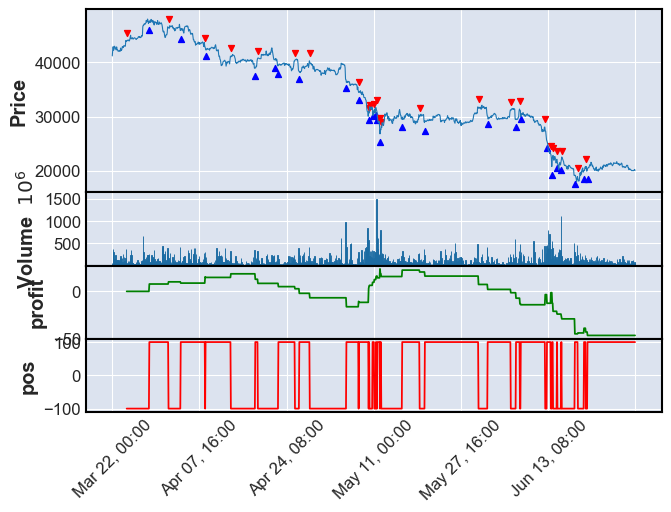

In [33]:
from matplotlib import markers

ohlcv_df = rbot.array_to_df(bb.ohlcv(0, 0, 60*60*2))            # ２時間足を作成（高頻度の場合修正要）

chart = pd.merge_asof(ohlcv_df, result_df, left_on="timestamp", right_on="create_time", direction="backward")       # ProfitとPositionの時間軸を合わせる。

# Long/Shortのポイントをみる。
long_event = result_df[result_df["order_type"]=="Buy"]
long_event.index = long_event.index.round("2H")                         # ２時間足に時刻を丸める（同じ時間に2つのイベントがあったら抜ける課題あり）
long_event = long_event.groupby("create_time").first()

short_event = result_df[result_df["order_type"]=="Sell"]
short_event.index = short_event.index.round("2H")                         # ２時間足に時刻を丸める（同じ時間に2つのイベントがあったら抜ける課題あり）
short_event = short_event.groupby("create_time").first()

long_event = pd.merge_ordered(ohlcv_df, long_event, left_on='timestamp', right_on='create_time')
short_event = pd.merge_ordered(ohlcv_df, short_event, left_on='timestamp', right_on='create_time')

mark_offset = 1500

ap2 = [
    mpf.make_addplot(chart['sum_profit'], type='line', color='g', panel=2, ylabel="profit"),
    mpf.make_addplot(chart['sum_pos'], type='line', color='r', panel=3, ylabel="pos"),    
    mpf.make_addplot(long_event['price']-mark_offset, type='scatter', color='b', panel=0, marker="^"),
    mpf.make_addplot(short_event['price']+mark_offset, type='scatter', color='r', panel=0, marker="v")   
]

mpf.plot(ohlcv_df, volume=True, type='line', addplot=ap2)


#### 雜に拡大

選択範囲に売／買のイベントがないとエラーになる雑なコードですが拡大してみます。
多分、当初の目的通り実装されているように見える。

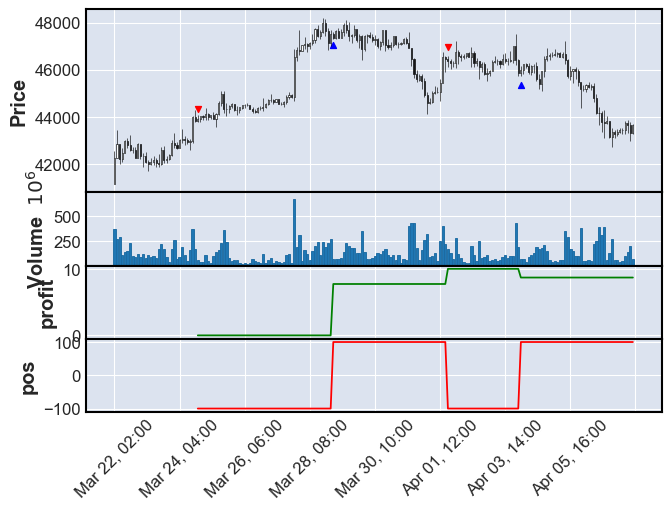

In [34]:
start=1
width=200


ap2 = [
    mpf.make_addplot(chart[start:start+width]['sum_profit'], type='line', color='g', panel=2, ylabel="profit"),
    mpf.make_addplot(chart[start:start+width]['sum_pos'], type='line', color='r', panel=3, ylabel="pos"),    
    mpf.make_addplot(long_event[start:start+width]['price']-500, type='scatter', color='b', panel=0, marker="^"),
    mpf.make_addplot(short_event[start:start+width]['price']+500, type='scatter', color='r', panel=0, marker="v")   
]

mpf.plot(ohlcv_df[start:start+width], volume=True, type='candle', addplot=ap2)

### 5.1 その他いろいろ分析

In [35]:
# オーダー回数の分析
g = result_df.groupby(["order_type", "status"])["status"].count()
g



order_type  status
Buy         Close     25
            Expire     1
            Open      25
Sell        Close     24
            Open      25
Name: status, dtype: int64

In [36]:
# 勝率の分析

win_trade = len(result_df[0 < result_df["total_profit"]])
loss_trade = len(result_df[result_df["total_profit"] < 0])

print("買った数:", win_trade)
print("負けた数:", loss_trade)
print("勝率:", win_trade/(loss_trade+win_trade))



買った数: 18
負けた数: 81
勝率: 0.18181818181818182


In [37]:
# 利益のピーク
result_df["sum_profit"].max()

23.78004615805436

In [38]:
# 最終利益
result_df["sum_profit"][-1]

-46.60542329823791

In [39]:
# 1回の取引の最大利益
result_df["total_profit"].max()

14.652098102160643

In [24]:
# １回の取引の最大損失
result_df["total_profit"].min()

-15.834009202133222